In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# additional imports
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [4]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [5]:
# number of classes
K = len(set(y_train.flatten()))
print("number of classes:", K)

number of classes: 10


In [6]:
#mean = np.mean(x_train,axis=(0,1,2,3))
#std = np.std(x_train,axis=(0,1,2,3))
#x_train = (x_train-mean)/(std+1e-7)
#x_test = (x_test-mean)/(std+1e-7)
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)
print("x_train.shape:", x_train.shape)
print("y_train_cat.shape", y_train.shape)

x_train.shape: (50000, 32, 32, 3)
y_train_cat.shape (50000, 1)


In [7]:
import matplotlib.pyplot as plt

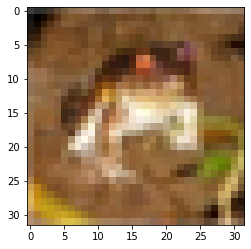

In [8]:
# FROG
plt.imshow(x_train[0])

In [9]:
x_train.shape[1:]

(32, 32, 3)

In [10]:
x_train[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

In [11]:
#rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=1e-7, verbose = 1, patience=5)
#es = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience=30)
#mc = ModelCheckpoint('cnn_best_model.h5', monitor='val_loss', mode='min', verbose = 1, save_best_only=True)
rlr = ReduceLROnPlateau(monitor='val_accuracy', mode = 'max', factor=0.5, min_lr=1e-7, verbose = 1, patience=10)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience=50)
mc = ModelCheckpoint('cnn_best_model.h5', monitor='val_accuracy', mode='max', verbose = 1, save_best_only=True)

In [12]:
# build model
def build_model(lr = 0, dc = 0, dr = 0):
    model = Sequential(name = 'CNN_cifar10')
    model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(256, activation='elu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(dr))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = optimizers.Adam(lr = lr, decay = dc)
    #opt = optimizers.SGD(lr = lr, momentum = mt)
    #opt = optimizers.RMSprop(lr = lr, decay = dc)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [13]:
model = build_model(lr = 0.001, dc = 1e-5, dr = 0.5)
#model = build_model(lr = 0.01, mt = 0.9, dr = 0.5)
#model = build_model(lr = 0.0003, dc = 1e-6, dr = 0.5)

In [14]:
model.summary()

Model: "CNN_cifar10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        

In [15]:
#data augmentation
datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False
        )
datagen.fit(x_train)

In [16]:
# run model
model.fit_generator(datagen.flow(x_train, y_train_cat, batch_size = 64),
                                 validation_data = (x_test, y_test_cat),
                                 steps_per_epoch = x_train.shape[0] // 64, 
                                 epochs = 400, verbose = 1,
                                 callbacks = [rlr, es, mc])


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/400
781/781 [==============================] - ETA: 0s - loss: 1.8105 - accuracy: 0.4163
Epoch 00001: val_accuracy improved from -inf to 0.56920, saving model to cnn_best_model.h5
781/781 [==============================] - 46s 58ms/step - loss: 1.8105 - accuracy: 0.4163 - val_loss: 1.3111 - val_accuracy: 0.5692 - lr: 0.0010
Epoch 2/400
781/781 [==============================] - ETA: 0s - loss: 1.3136 - accuracy: 0.5657
Epoch 00002: val_accuracy improved from 0.56920 to 0.60510, saving model to cnn_best_model.h5
781/781 [==============================] - 47s 61ms/step - loss: 1.3136 - accuracy: 0.5657 - val_loss: 1.2676 - val_accuracy: 0.6051 - lr: 0.0010
Epoch 3/400
781/781 [==============================] - ETA: 0s - loss: 1.1480 - accuracy: 0.6255
Epoch 00003: val_accuracy improved from 0.60510 to 0.68430, saving model to cnn_best_model.h5
781/781 [==============================] - 47s 61ms/step - los

In [17]:
ls

cnn_best_model.h5  sample_data/


In [18]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()
    

In [19]:
print(model.history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


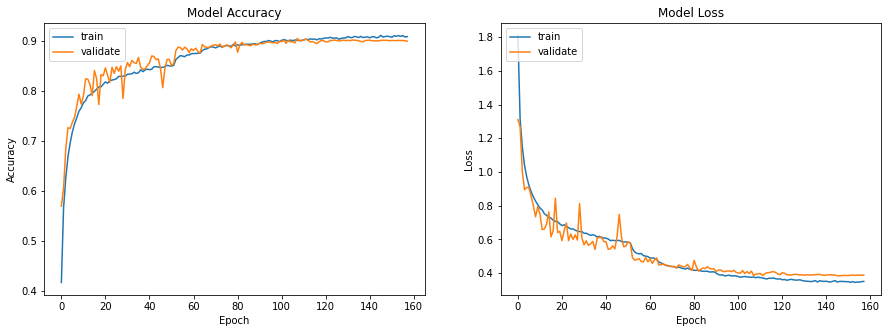

In [20]:
plotmodelhistory(model.history)

Confusion matrix, without normalization
[[910  11  13   2   5   0   8   6  27  18]
 [  2 967   0   0   0   0   0   0   4  27]
 [ 22   0 861  11  24  16  47  12   3   4]
 [ 11   4  30 728  35  73  70  21  12  16]
 [  2   1  19  13 903   3  36  23   0   0]
 [  2   4  16  69  25 815  30  27   4   8]
 [  4   1   6   5   2   0 976   3   1   2]
 [  3   1   3   6  13   7  10 950   3   4]
 [ 21  12   2   1   0   0   4   1 939  20]
 [  3  33   1   0   1   1   1   0   7 953]]


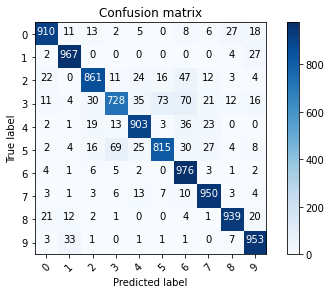

In [21]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [22]:
# label mapping
labels = '''airplane
      automobile
      bird
      cat
      deer
      dog
      frog
      horse
      ship
      truck'''.split()

Text(0.5, 1.0, 'True label: airplane, Predicted: automobile')

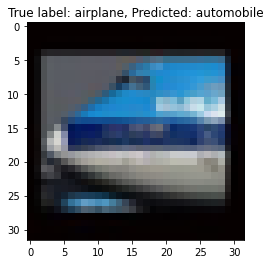

In [23]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test.flatten())[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s, Predicted: %s" % (labels[y_test.flatten()[i]], labels[p_test[i]]))
